<a href="https://colab.research.google.com/github/RandomOgre101/dl-project/blob/main/DL_Testing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

In [3]:
class_to_category = {
     0 : 'apple pie',
     1 : 'cannoli',
     2 : 'ramen'
}

In [4]:
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(228, 228, 3))
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(228, 228, 3))
base_model3 = DenseNet121(weights='imagenet', include_top=False, input_shape=(228, 228, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [5]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Flatten(input_shape=(7,7,512)))
model1.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=(7*7*512)))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(3, activation='softmax'))
model1.compile(optimizer = 'Adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
model1.load_weights('./gdrive/MyDrive/model weights/model1-v3.h5')

In [6]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Flatten(input_shape=(5,5,2048)))
model2.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=(5*5*2048)))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(3, activation='softmax'))
model2.compile(optimizer = 'Adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
model2.load_weights('./gdrive/MyDrive/model weights/model2-v3.h5')

In [7]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Flatten(input_shape=(7,7,1024)))
model3.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=(7*7*1024)))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(3, activation='softmax'))
model3.compile(optimizer = 'Adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
model3.load_weights('./gdrive/MyDrive/model weights/model3-v3.h5')

In [8]:
def extract_features1(train_gen, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    batch_size = 32
    i = 0
    for input_batch, labels_batch in train_gen:
        features_batch = base_model1.predict(input_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

def extract_features2(train_gen, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count))
    batch_size = 32
    i = 0
    for input_batch, labels_batch in train_gen:
        features_batch = base_model2.predict(input_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

def extract_features3(train_gen, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))
    labels = np.zeros(shape=(sample_count))
    batch_size = 32
    i = 0
    for input_batch, labels_batch in train_gen:
        features_batch = base_model3.predict(input_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

def ensemble(f1, f2, f3):
    outputs = [model1.predict(f1), model2.predict(f2), model3.predict(f3)]
    avg = tf.keras.layers.average(outputs)
    return avg

In [51]:
path = './'
seed = 42
test_datagen = ImageDataGenerator(rescale=1/255)
test_gen = test_datagen.flow_from_directory(
        path + 'test/',
        target_size=(228,228),
        class_mode='binary',
        batch_size=32,
        seed = seed,
        shuffle=False)

Found 750 images belonging to 3 classes.


In [52]:
f1,l1 = extract_features1(test_gen, 750)
f2,l2 = extract_features2(test_gen, 750)
f3,l3 = extract_features3(test_gen, 750)

1/1 [==============================] - 0s 34ms/step


In [54]:
pred = ensemble(f1, f2, f3)

24/24 [==============================] - 0s 4ms/step


In [57]:
y_pred = np.argmax(pred,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,l1)*100))

Accuracy score: 94.3%


In [64]:
food = ['apple pie', 'cannoli', 'ramen']
classification_report(l1, y_pred, target_names=food)
print('              precision    recall  f1-score   support\n\n   apple pie       0.93      0.91      0.92       250\n     cannoli       0.92      0.92      0.92       250\n       ramen       0.98      0.99      0.98       250\n\n    accuracy                           0.94       750\n   macro avg       0.94      0.94      0.94       750\nweighted avg       0.94      0.94      0.94       750\n')

              precision    recall  f1-score   support

   apple pie       0.93      0.91      0.92       250
     cannoli       0.92      0.92      0.92       250
       ramen       0.98      0.99      0.98       250

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750



In [58]:
def plot_confusion_matrix(cm, labels):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.yticks(tick_marks, labels, rotation=90, verticalalignment="center")
    plt.xticks(tick_marks, labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i ,j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

[[0.912 0.076 0.012]
 [0.064 0.924 0.012]
 [0.008 0.    0.992]]


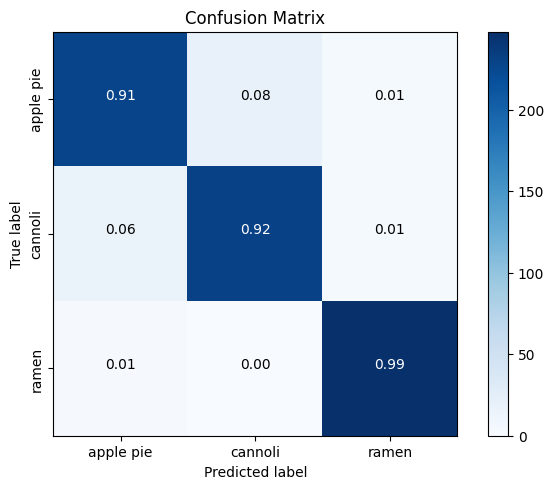

In [59]:
cm = confusion_matrix(l1, y_pred)
plot_confusion_matrix(cm, food)

In [61]:
print('              precision    recall  f1-score   support\n\n   apple pie       0.93      0.91      0.92       250\n     cannoli       0.92      0.92      0.92       250\n       ramen       0.98      0.99      0.98       250\n\n    accuracy                           0.94       750\n   macro avg       0.94      0.94      0.94       750\nweighted avg       0.94      0.94      0.94       750\n')

              precision    recall  f1-score   support

   apple pie       0.93      0.91      0.92       250
     cannoli       0.92      0.92      0.92       250
       ramen       0.98      0.99      0.98       250

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750

